Please upload a ZIP file containing airfoil data.


Saving NACA 23012.zip to NACA 23012 (1).zip
Files extracted to ./airfoil_data/NACA 23012


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Using device: cuda
Enter your query (or type 'exit' to quit): cp distribution, angle -14.04, mach 0.12, re 1.46e6
BERT raw output for Angle of Attack: -14.04, mach 0.12, re 1.46e6
BERT raw output for Mach Number: mach 0.12, re 1.46e6
BERT raw output for Reynolds Number: re 1.46e6
Extracted Parameters: {'Angle of Attack': -14.04, 'Mach Number': 0.12, 'Reynolds Number': 1460000.0}
Checking filename: NACA 23012_coordinates.csv
No match found for NACA 23012_coordinates.csv
Checking filename: NACA 23012_A2.70_M0.12_Re1.46e6_A.csv
Extracted from NACA 23012_A2.70_M0.12_Re1.46e6_A.csv: {'angle_of_attack': 2.7, 'mach_number': 0.12, 'reynolds_number': 1460000.0, 'filename': 'NACA 23012_A2.70_M0.12_Re1.46e6_A.csv'}
Checking filename: NACA 23012_A2.70_M0.12_Re1.46e6_A.csv
Extracted from NACA 23012_A2.70_M0.12_Re1.46e6_A.csv: {'angle_of_attack': 2.7, 'mach_number': 0.12, 'reynolds_number': 1460000.0, 'filename': 'NACA 23012_A2.70_M0.12_Re1.46e6_A.csv'}
Checking filename: NACA 23012_Am9.710_M0.12_Re

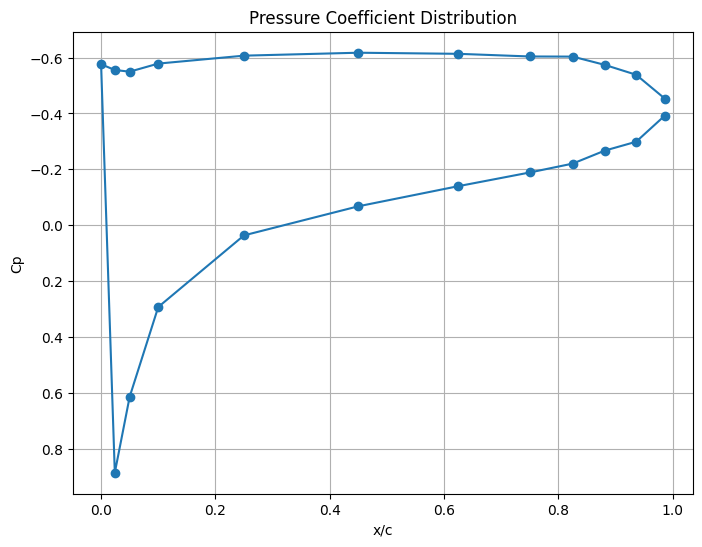

KeyboardInterrupt: Interrupted by user

In [ ]:
!pip install transformers pandas torch

import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForQuestionAnswering, pipeline
from google.colab import files
import zipfile

def upload_airfoil_folder():
    print("Please upload a ZIP file containing airfoil data.")
    uploaded = files.upload()
    zip_filename = list(uploaded.keys())[0]
    extract_folder = "./airfoil_data"

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

    extracted_subfolder = os.path.join(extract_folder, os.listdir(extract_folder)[0])
    print(f"Files extracted to {extracted_subfolder}")
    return extracted_subfolder

def load_bert_pipeline():
    tokenizer = BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
    model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    print(f"Using device: {device}")

    qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0 if device == "cuda" else -1)
    return qa_pipeline

def extract_metadata_from_filename(filename):
    print(f"Checking filename: {filename}")

    match = re.search(r'A(m?[-+]?\d*\.\d+|\d+)_M([-+]?\d*\.\d+|\d+)_Re((?:\d+\.\d+|\d+)(?:e[+-]?\d+)?)', filename, re.IGNORECASE)

    if match:
        aoa_value = match.group(1)
        if aoa_value.startswith("m"):
            aoa_value = -float(aoa_value[1:])
        else:
            aoa_value = float(aoa_value)

        extracted_data = {
            "angle_of_attack": aoa_value,
            "mach_number": float(match.group(2)),
            "reynolds_number": float(match.group(3)),
            "filename": filename
        }
        print(f"Extracted from {filename}: {extracted_data}")
        return extracted_data

    print(f"No match found for {filename}")
    return None

def extract_query_parameters(query, qa_pipeline):
    """
    Uses BERT to extract Angle of Attack, Mach Number, and Reynolds Number from the query.
    Accepts:
    - 'angle of attack', 'a', or '__ degrees' for AoA
    - 'mach number' or 'm' for Mach
    - 'reynolds number' or 're' for Re
    """
    parameters = {
        "Angle of Attack": ["angle of attack", "angle", "degrees"],
        "Mach Number": ["mach number", "m"],
        "Reynolds Number": ["reynolds number", "re"]
    }

    extracted_parameters = {}

    for param, keywords in parameters.items():
        context = f"The {param} value is specified in the following sentence: {query}"
        try:
            response = qa_pipeline(question=param, context=context)
            extracted_value = response["answer"]

            print(f"BERT raw output for {param}: {extracted_value}")

            for keyword in keywords:
                extracted_value = extracted_value.replace(keyword, "").strip()

            match = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", extracted_value)
            if match:
                extracted_value = float(match.group(0))
            else:
                extracted_value = None

            extracted_parameters[param] = extracted_value

        except Exception as e:
            print(f"Error extracting {param}: {e}")
            extracted_parameters[param] = None

    print(f"Extracted Parameters: {extracted_parameters}")
    return extracted_parameters

def plot_airfoil_data(file_path):
    df = pd.read_csv(file_path, skiprows=1, header=None)
    plt.figure(figsize=(8, 6))
    plt.plot(df[0], df[1], marker='o', linestyle='-')
    plt.xlabel("x/c")
    plt.ylabel("Cp")
    plt.title("Pressure Coefficient Distribution")
    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

def process_user_query():
    folder_path = upload_airfoil_folder()
    qa_pipeline = load_bert_pipeline()

    while True:
        query = input("Enter your query (or type 'exit' to quit): ")
        if query.lower() == "exit":
            print("Exiting...")
            break

        query_params = extract_query_parameters(query, qa_pipeline)
        if not query_params or None in query_params.values():
            print("Failed to extract parameters. Please try again.")
            continue

        files = os.listdir(folder_path)
        metadata_list = [extract_metadata_from_filename(file) for file in files if extract_metadata_from_filename(file)]
        print(f"Extracted Metadata from Filenames: {metadata_list}")

        best_match = None
        best_score = float('inf')

        for metadata in metadata_list:
            score = abs(metadata["angle_of_attack"] - query_params["Angle of Attack"]) + \
                    abs(metadata["mach_number"] - query_params["Mach Number"]) + \
                    abs(metadata["reynolds_number"] - query_params["Reynolds Number"])
            if score < best_score:
                best_match = metadata["filename"]
                best_score = score

        if best_match:
            print(f"Found file: {best_match}")
            file_path = os.path.join(folder_path, best_match)
            plot_airfoil_data(file_path)
        else:
            print("No matching data file found. Please try again.")

if __name__ == "__main__":
    process_user_query()
